task: https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing

This project is based on a mini project from Datacamp.

In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40.

# import

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from sklearn.ensemble import IsolationForest

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm.auto import tqdm

In [2]:
def remove_outliers_isolation_forest(data, contamination=0.05):
    clf = IsolationForest(contamination=contamination) # contamination - доля аномалий в данных
    y_pred = clf.fit_predict(data.reshape(-1, 1))

    return y_pred


def remove_outliers_iqr(data, q1=25, q2=75):
    Q1 = np.percentile(data, q1)
    Q3 = np.percentile(data, q2)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return [lower_bound, upper_bound]


def get_print_result(p_value):
    if p_value < 0.05: print('H0 rejected. p-value={}'.format(p_value))
    else: print('Сan\'t reject H0. p-value={}'.format(p_value))


def get_ztest(group1, group2, print_result=False):
    # Количество успехов в каждой выборке
    count = np.array([
        np.count_nonzero(group1),
        np.count_nonzero(group2)
    ])

    # Общее количество испытаний в каждой выборке
    nobs = np.array([
        np.size(group1),
        np.size(group2)
    ])

    # Выполняем Z-тест для пропорций
    z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')

    if print_result: get_print_result(p_value)
    else: return p_value


def get_chi2test(group1, group2, print_result=False):
    # Таблица сопряженности количества успехов и неудач в каждой выборке
    contingency_table = np.array([
        [np.count_nonzero(group1), np.size(group1)],
        [np.count_nonzero(group2), np.size(group1)]
    ])

    # Выполнение теста Хи-квадрат Пирсона (независимость)
    chi2, p_value, dof, expected_freq = stats.chi2_contingency(contingency_table)

    if print_result: get_print_result(p_value)
    else: return p_value


def ttest_welch(group1, group2, print_result=False):
    # Выполнение t-теста Уэлча
    p_value = stats.ttest_ind(group1, group2, equal_var=False).pvalue

    if print_result: get_print_result(p_value)
    else: return p_value


def ttest_student(group1, group2, print_result=False):
    # Выполнение t-теста Стьюдента
    p_value = stats.ttest_ind(group1, group2, equal_var=True).pvalue

    if print_result: get_print_result(p_value)
    else: return p_value


def get_mannwhitneyu_test(group1, group2, print_result=False):
    # Выполнение t-теста Стьюдента
    p_value = stats.mannwhitneyu(group1, group2).pvalue

    if print_result: get_print_result(p_value)
    else: return p_value


# Функция взята из karpov.courses (немного модернизирована, pd.sample заменен на np.random.choice)
def get_bootstrap(
    group1, # числовые значения первой выборки
    group2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = np.max([np.size(group1), np.size(group2)])
    boot_data = []

    for i in tqdm(range(boot_it)):
        samples_1 = np.random.choice(
            group1,
            size=boot_len,
            replace=True, # выбранные значения доступны для повторного взятия
            p=None
        )
        samples_2 = np.random.choice(
            group2,
            size=boot_len,
            replace=True,
            p=None
        )
        boot_data.append(statistic(samples_1-samples_2))


    pd_boot_data = pd.DataFrame(boot_data)

    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])

    p_1 = stats.norm.cdf(
        x = 0,
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0,
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else:
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')

    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()

    return {
        "boot_data": boot_data,
        "quants": quants,
        "p_value": p_value
    }

# data explore

In [3]:
filepath = 'cookie_cats.csv'

df = pd.read_csv(filepath)

# the first gate in Cookie Cats was moved from level 30 to level 40
df.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
display(
  df.userid.nunique(),
  df.version.value_counts()
)

90189

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Text(0.5, 1.0, "y='sum_gamerounds' where df.retention_7 == True")

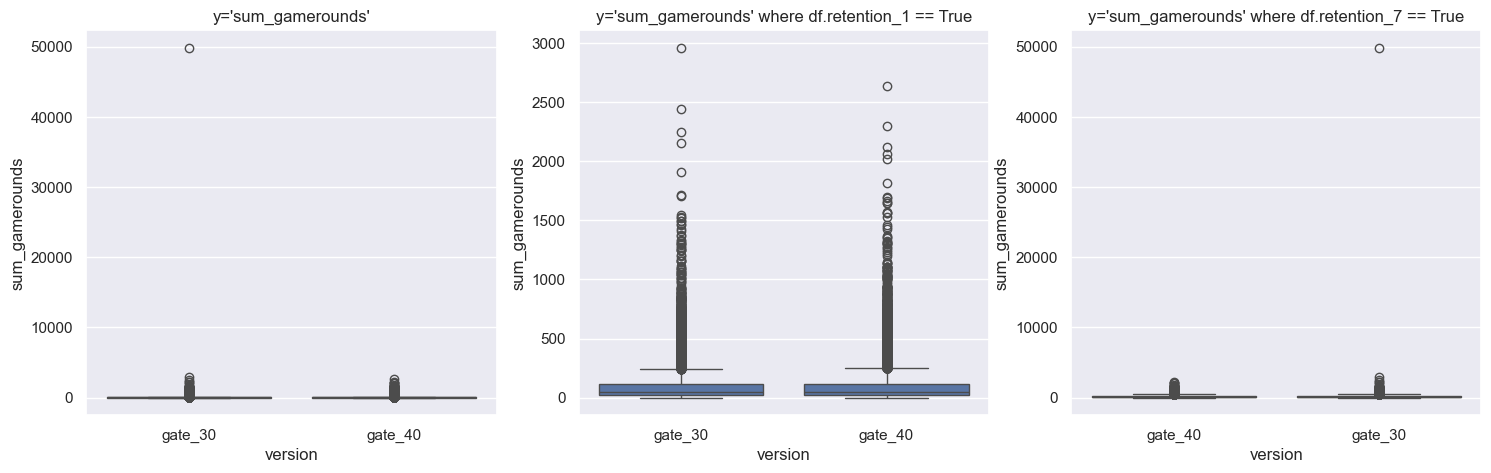

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(18, 5))

sns.boxplot(ax=axes[0], data=df, y='sum_gamerounds', x='version')
sns.boxplot(ax=axes[1], data=df[df.retention_1 == True], y='sum_gamerounds', x='version')
sns.boxplot(ax=axes[2], data=df[df.retention_7 == True], y='sum_gamerounds', x='version')

axes[0].set_title("y='sum_gamerounds'")
axes[1].set_title("y='sum_gamerounds' where df.retention_1 == True")
axes[2].set_title("y='sum_gamerounds' where df.retention_7 == True")

In [7]:
# df --> data without outliers

df_gate_30 = df[df.version == 'gate_30'].copy()
df_gate_40 = df[df.version == 'gate_40'].copy()

df_gate_30['outliers'] = remove_outliers_isolation_forest(df_gate_30.sum_gamerounds.values, 0.05)
df_gate_40['outliers'] = remove_outliers_isolation_forest(df_gate_40.sum_gamerounds.values, 0.05)

data = pd.concat([df_gate_30, df_gate_40])

del df_gate_30, df_gate_40

data = data[data.outliers != -1]

Text(0.5, 1.0, "y='sum_gamerounds' where data.retention_7 == True")

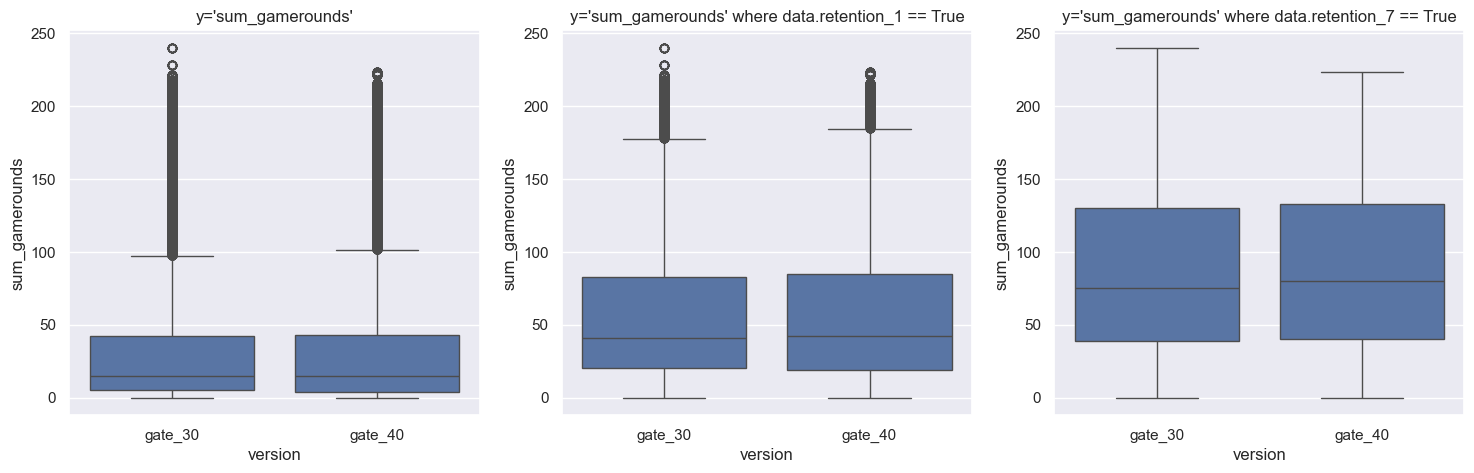

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(18, 5))

sns.boxplot(ax=axes[0], data=data, y='sum_gamerounds', x='version')
sns.boxplot(ax=axes[1], data=data[data.retention_1 == True], y='sum_gamerounds', x='version')
sns.boxplot(ax=axes[2], data=data[data.retention_7 == True], y='sum_gamerounds', x='version')

axes[0].set_title("y='sum_gamerounds'")
axes[1].set_title("y='sum_gamerounds' where data.retention_1 == True")
axes[2].set_title("y='sum_gamerounds' where data.retention_7 == True")

In [9]:
display(
  data.userid.nunique(),
  data.version.value_counts()
)

85692

version
gate_40    43216
gate_30    42476
Name: count, dtype: int64

In [10]:
data['retention_1'] = data['retention_1'].apply(lambda x: 1 if x == True else 0 )
data['retention_7'] = data['retention_7'].apply(lambda x: 1 if x == True else 0 )

In [11]:
data.groupby(by='version').describe()['sum_gamerounds']

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,42476.0,33.239194,44.169049,0.0,5.0,15.0,42.0,240.0
gate_40,43216.0,33.057340,43.997770,0.0,4.0,15.0,43.0,223.0


# testing

Метрики для тестирования:
- ср кол-во пройденных уровней
- конверсия в ретеншен 1 и 7 дня

Гипотезы:
- H0: gate_30 == gate_40
- H1: gate_30 != gate_40

## Среднее кол-во пройденных уровней

### все данные (вкл тех, кто не дошел до 30 уровня)

In [12]:
group1 = data[data.version == 'gate_30'].sum_gamerounds.values
group2 = data[data.version == 'gate_40'].sum_gamerounds.values

In [13]:
# Variance test
# Levene’s test is an alternative to Bartlett’s test. For samples from significantly non-normal populations, Levene’s test levene is more robust.
#   H0: equal variances
#   H1: not equal variances


res = stats.levene(group1, group2, center='median')

print('stat: {}'.format(res.statistic))
get_print_result(res.pvalue)


res = stats.levene(group1, group2, center='mean')

print('stat: {}'.format(res.statistic))
get_print_result(res.pvalue)

stat: 0.012537817772133301
Сan't reject H0. p-value=0.9108455548681593
stat: 2.041031215619341
Сan't reject H0. p-value=0.15310946726283556


Распределение значений отлично от нормального, но у нас достаточно большая выборка и равная дисперсия, поэтому можно применить параметрический **t-тест**. Также, оценим непараметрические тесты: **Манн-Уитни, бутстрап**. Но Манн-Уитни не подходит для сранения средних/медианы, поэтому в приоритете  остается t-тест и бутстрап.

В случае t-тест, он предполагает нормальное распределение, но в силу ЦПТ и равной дисперсии, этим можно пренебречь.

In [14]:
# mannwhitneyu // для примера

get_mannwhitneyu_test(group1, group2, print_result=True)

H0 rejected. p-value=0.030958565866983083


In [15]:
# student - ttest for equal variances

ttest_student(group1, group2, print_result=True)

Сan't reject H0. p-value=0.5459920380775293


In [16]:
# welch - ttest for not equal variances // для примера

ttest_welch(group1, group2, print_result=True)

Сan't reject H0. p-value=0.5460055090149278


  0%|          | 0/10000 [00:00<?, ?it/s]

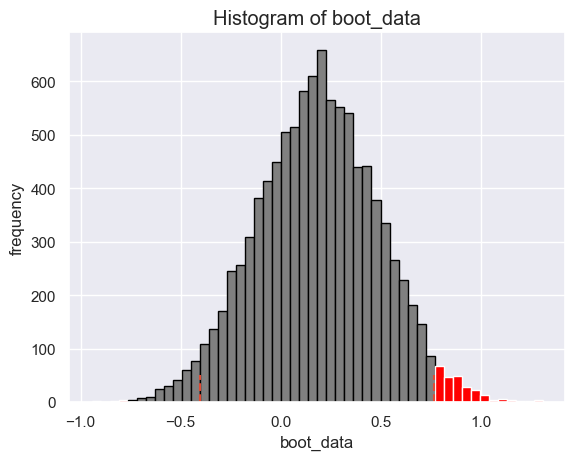

Сan't reject H0. p-value=0.5371946715286708
              0
0.025 -0.404342
0.975  0.766057


In [17]:
# mean

res = get_bootstrap(group1,
                    group2,
                    boot_it = 10000,
                    statistic = np.mean,
                    bootstrap_conf_level = 0.95)

get_print_result(res['p_value'])
print(res['quants'])

In [18]:
del group1, group2

### тест только на тех пользователя, которые достигли 30 уровня

логично предположить, что изменения никак не повлияют на пользователей, которые не достагли 30 уровня, поэтому их нужно исключить.

In [19]:
data[(data.sum_gamerounds >= 30)].version.value_counts()

version
gate_30    14432
gate_40    14340
Name: count, dtype: int64

<Axes: xlabel='sum_gamerounds', ylabel='Count'>

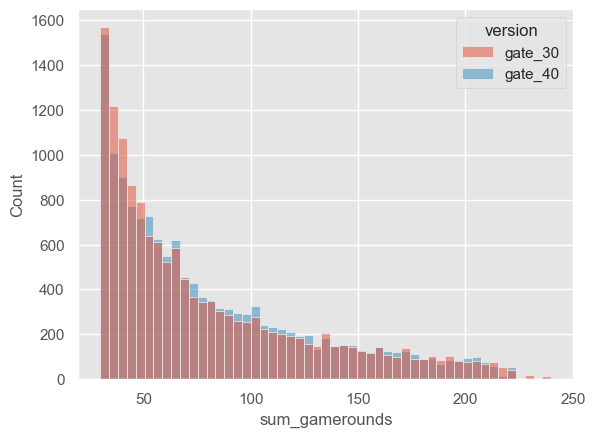

In [20]:
sns.histplot(data[(data.sum_gamerounds >= 30)], hue='version', x='sum_gamerounds')

In [21]:
group1 = data[(data.version == 'gate_30') & (data.sum_gamerounds >= 30)].sum_gamerounds.values
group2 = data[(data.version == 'gate_40') & (data.sum_gamerounds >= 30)].sum_gamerounds.values

In [22]:
# Variance test
# Levene’s test is an alternative to Bartlett’s test. For samples from significantly non-normal populations, Levene’s test levene is more robust.
#   H0: equal variances
#   H1: not equal variances


res = stats.levene(group1, group2, center='median')

print('stat: {}'.format(res.statistic))
get_print_result(res.pvalue)


res = stats.levene(group1, group2, center='mean')

print('stat: {}'.format(res.statistic))
get_print_result(res.pvalue)

stat: 0.22738811878611062
Сan't reject H0. p-value=0.6334709202758122
stat: 3.973817237040928
H0 rejected. p-value=0.046222323943195996


In [23]:
# mannwhitneyu // для примера

get_mannwhitneyu_test(group1, group2, print_result=True)

H0 rejected. p-value=2.101064869027113e-05


In [24]:
# student - ttest for equal variances

ttest_student(group1, group2, print_result=True)

H0 rejected. p-value=0.014669908577944004


In [25]:
# welch - ttest for not equal variances // для примера

ttest_welch(group1, group2, print_result=True)

H0 rejected. p-value=0.014663512197157103


  0%|          | 0/10000 [00:00<?, ?it/s]

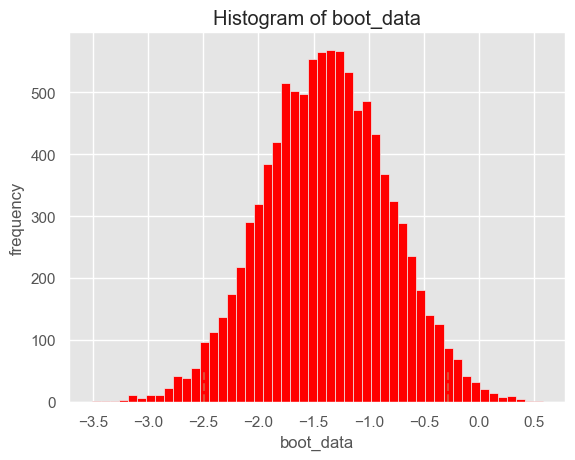

H0 rejected. p-value=0.014240847773086507
              0
0.025 -2.494829
0.975 -0.283114


In [26]:
# bootstrap - mean

res = get_bootstrap(group1,
                    group2,
                    boot_it = 10000,
                    statistic = np.mean,
                    bootstrap_conf_level = 0.95)

get_print_result(res['p_value'])
print(res['quants'])

In [27]:
del group1, group2

## Конверсия в возврат в приложение на 1/7 день

Для оценки конверсии подойдут: z-тест пропорций, бутстрап.

In [28]:
data.groupby(by='version').agg({'retention_1': 'sum', 'retention_7': 'sum'})

,retention_1,retention_7
version,,
gate_30,17939,6568
gate_40,17991,6308


### все данные (вкл тех, кто не дошел до 30 уровня)

#### retention_1

In [29]:
group1 = data[data.version == 'gate_30'].retention_1.values
group2 = data[data.version == 'gate_40'].retention_1.values

In [30]:
# ztest

get_ztest(group1, group2, print_result=True)

Сan't reject H0. p-value=0.07375879357230213


In [31]:
# student - ttest for equal variances

ttest_student(group1, group2, print_result=True)

Сan't reject H0. p-value=0.07376031050647856


  0%|          | 0/10000 [00:00<?, ?it/s]

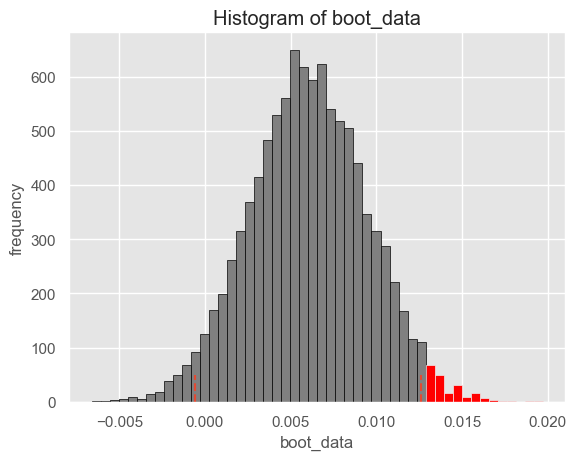

Сan't reject H0. p-value=0.07422556981268334
              0
0.025 -0.000578
0.975  0.012634


In [32]:
# bootstrap - mean

res = get_bootstrap(group1,
                    group2,
                    boot_it = 10000,
                    statistic = np.mean,
                    bootstrap_conf_level = 0.95)

get_print_result(res['p_value'])
print(res['quants'])

In [33]:
del group1, group2

#### retention_7

In [34]:
group1 = data[data.version == 'gate_30'].retention_7.values
group2 = data[data.version == 'gate_40'].retention_7.values

In [35]:
# ztest

get_ztest(group1, group2, print_result=True)

H0 rejected. p-value=0.00038700068844273113


In [36]:
# student - ttest for equal variances

ttest_student(group1, group2, print_result=True)

H0 rejected. p-value=0.00038688514792768215


  0%|          | 0/10000 [00:00<?, ?it/s]

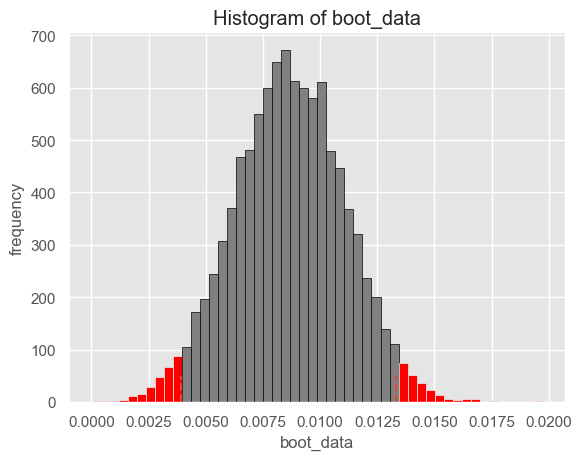

H0 rejected. p-value=0.00030781578918625993
              0
0.025  0.003911
0.975  0.013305


In [37]:
# bootstrap - mean

res = get_bootstrap(group1,
                    group2,
                    boot_it = 10000,
                    statistic = np.mean,
                    bootstrap_conf_level = 0.95)

get_print_result(res['p_value'])
print(res['quants'])

In [38]:
del group1, group2

### тест только на тех пользователя, которые достигли 30 уровня

#### retention_1

In [39]:
group1 = data[(data.version == 'gate_30') & (data.sum_gamerounds >= 30)].retention_1.values
group2 = data[(data.version == 'gate_40') & (data.sum_gamerounds >= 30)].retention_1.values

In [40]:
# ztest

get_ztest(group1, group2, print_result=True)

Сan't reject H0. p-value=0.789626094354898


In [41]:
# student - ttest for equal variances

ttest_student(group1, group2, print_result=True)

Сan't reject H0. p-value=0.7896348923901245


  0%|          | 0/10000 [00:00<?, ?it/s]

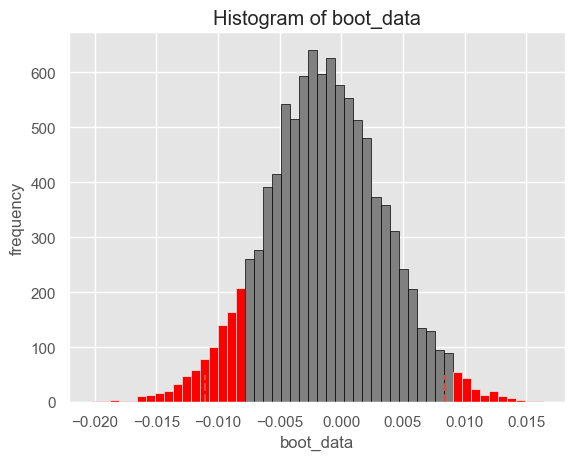

Сan't reject H0. p-value=0.7847988880918337
              0
0.025 -0.011086
0.975  0.008384


In [42]:
# bootstrap - mean

res = get_bootstrap(group1,
                    group2,
                    boot_it = 10000,
                    statistic = np.mean,
                    bootstrap_conf_level = 0.95)

get_print_result(res['p_value'])
print(res['quants'])

In [43]:
del group1, group2

#### retention_7

In [44]:
group1 = data[(data.version == 'gate_30') & (data.sum_gamerounds >= 30)].retention_7.values
group2 = data[(data.version == 'gate_40') & (data.sum_gamerounds >= 30)].retention_7.values

In [45]:
# ztest

get_ztest(group1, group2, print_result=True)

H0 rejected. p-value=0.04070287225057903


In [46]:
# student - ttest for equal variances

ttest_student(group1, group2, print_result=True)

H0 rejected. p-value=0.04070429062495133


  0%|          | 0/10000 [00:00<?, ?it/s]

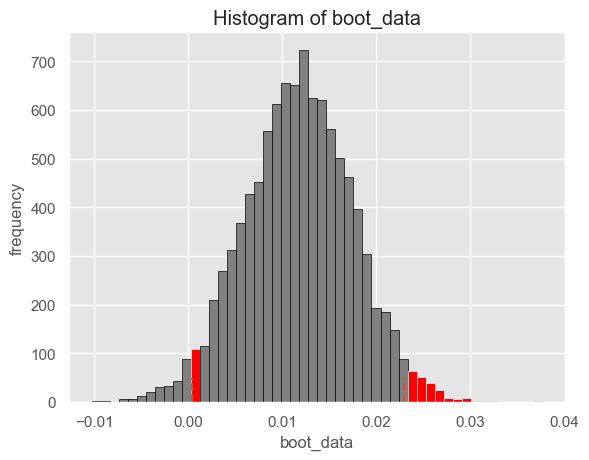

H0 rejected. p-value=0.04074887413855882
              0
0.025  0.000346
0.975  0.022935


In [47]:
# bootstrap - mean

res = get_bootstrap(group1,
                    group2,
                    boot_it = 10000,
                    statistic = np.mean,
                    bootstrap_conf_level = 0.95)

get_print_result(res['p_value'])
print(res['quants'])

In [48]:
del group1, group2

# Вывод

Тестировали влияние увеличения уровня, когда игрок впервые сталкивается с ограничениями, которые заставляют его ждать некоторое время, прежде чем он сможет продвинуться вперед, на ретеншен 1 и 7 дня. Дополнительно оценили влияние изменений на среднее количество пройденных уровней.

Так как изменения затронули только тех пользователей, которые достигли 30 уровня, то выводы будут основаны на них.

1. Retention_1. Тестирование показало, что в значении ретеншена 1 дня нет стат значимого отличия между группами gate_30 и gate_40 (не можем отвергнуть нулевую гипотезу, p-value=0.78).
2. Retention_7. В отличии от ретеншена 1 дня, тестирование ретеншена 7-го дня показало, что различие стат значимо (p-value=0.04), при этом разница положительная (база - тест), то есть ретеншен тестируемой группы меньше, чем у базовой.
3. Кол-во пройденных уровней. Ожидаемо, среднее кол-во пройденных уровней увеличилось в тестируемой группы относительно базовой - различие статистически значимо (p-value=0.014).

Общий вывод: тест показа, что повышение порога не оказало положительного влияния на ретеншен пользователей.